## Importing the Libraries

In [24]:
#dataset link: https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

import cv2
import imageio
from PIL import Image
import numpy as np
from keras.preprocessing.image import img_to_array
from keras import backend as K
from keras.layers import Layer
from keras.layers import Input
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import argparse
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import glob


In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts
    

In [3]:
filelist_trainx = sorted(glob.glob('../input/*/trainx/*.bmp'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])



filelist_trainy = sorted(glob.glob('../input/*/trainy/*.bmp'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25)

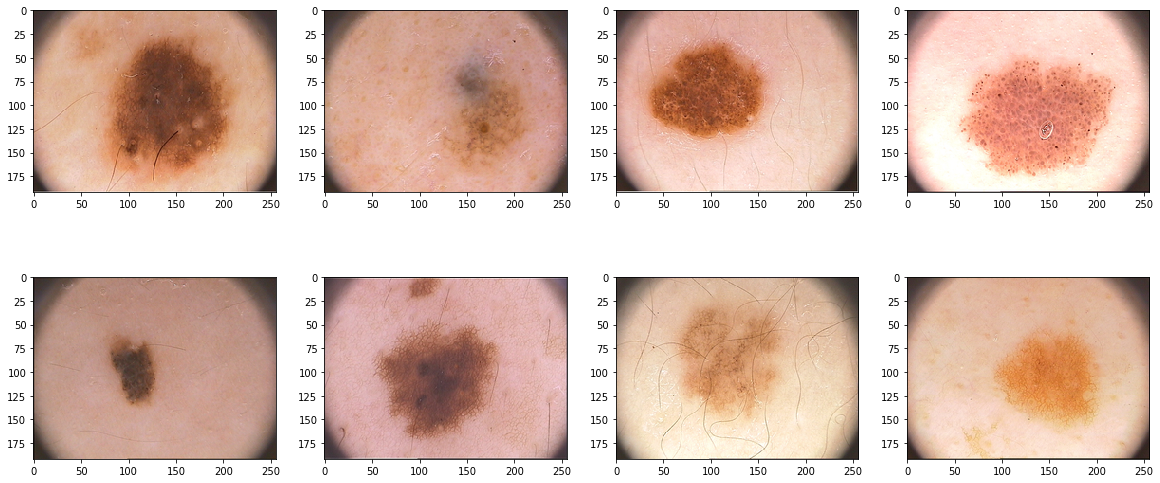

In [5]:
plt.figure(figsize=(20, 9))
plt.subplot(2, 4, 1)
plt.imshow(X_train[0])
plt.subplot(2, 4, 2)
plt.imshow(X_train[3])
plt.subplot(2, 4, 3)
plt.imshow(X_train[10])
plt.subplot(2, 4, 4)
plt.imshow(X_train[100])
plt.subplot(2, 4, 5)
plt.imshow(X_train[130])
plt.subplot(2, 4, 6)
plt.imshow(X_train[170])
plt.subplot(2, 4, 7)
plt.imshow(X_train[140])
plt.subplot(2, 4, 8)
plt.imshow(X_train[160])
plt.show()

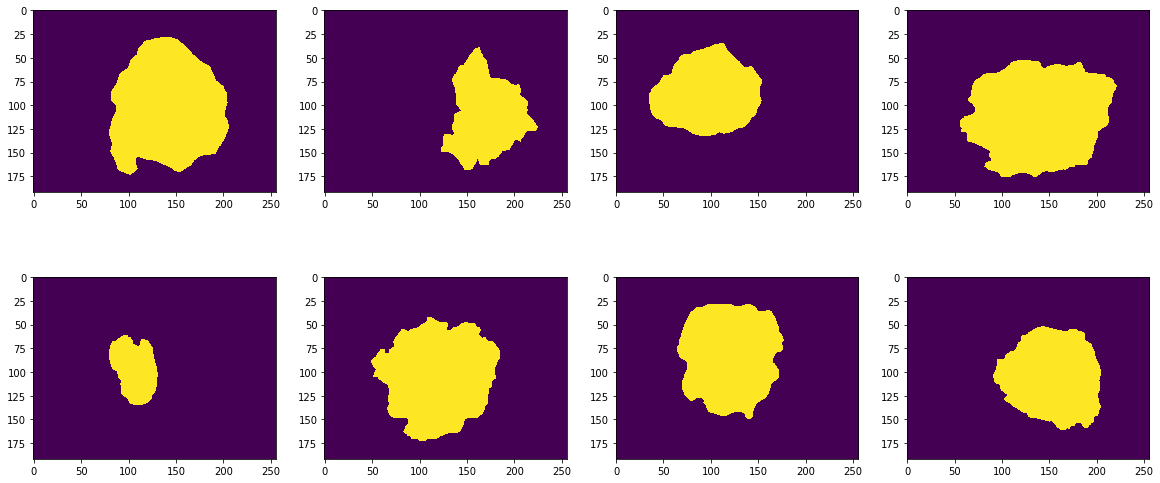

In [6]:
plt.figure(figsize=(20, 9))
plt.subplot(2, 4, 1)
plt.imshow(Y_train[0])
plt.subplot(2, 4, 2)
plt.imshow(Y_train[3])
plt.subplot(2, 4, 3)
plt.imshow(Y_train[10])
plt.subplot(2, 4, 4)
plt.imshow(Y_train[100])
plt.subplot(2, 4, 5)
plt.imshow(Y_train[130])
plt.subplot(2, 4, 6)
plt.imshow(Y_train[170])
plt.subplot(2, 4, 7)
plt.imshow(Y_train[140])
plt.subplot(2, 4, 8)
plt.imshow(Y_train[160])
plt.show()

In [7]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [8]:
def dice(y_true, y_pred):
    y_true_a = K.flatten(y_true)
    y_pred_a = K.flatten(y_pred)
    intersection = K.sum(y_true_a * y_pred_a)
    return (2 * intersection)/(K.sum(y_true_a) + K.sum(y_pred_a))
    

In [9]:
import cv2

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [10]:
def img_augmentation(xx, yy):
    x_flip = []
    y_flip = []
    for idx  in range(len(xx)):
        x, y = horizontal_flip(xx[idx], yy[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_flip), np.array(y_flip)

In [11]:
x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

In [12]:
x_flipped_t.shape

(50, 192, 256, 3)

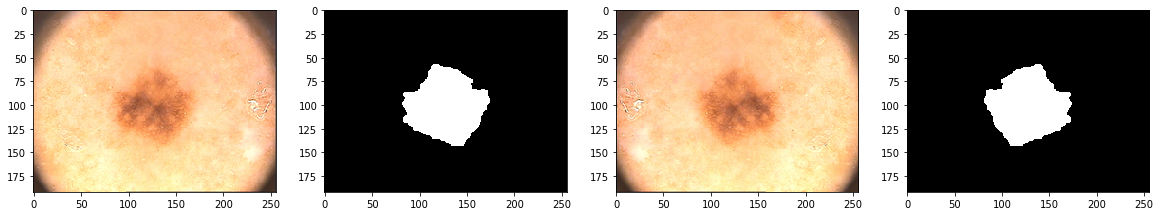

In [13]:
plt.figure(figsize=(20, 9))
plt.subplot(2, 4, 1)
plt.imshow(x_train[3])
plt.subplot(2, 4, 2)
plt.imshow(y_train[3], cmap='gray')
plt.subplot(2, 4, 3)
plt.imshow(x_flipped[3])
plt.subplot(2, 4, 4)
plt.imshow(y_flipped[3], cmap='gray')


plt.show()

In [14]:
x_train_full = np.concatenate([x_train, x_flipped])
y_train_full  = np.concatenate([y_train, y_flipped])

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [16]:
len(x_train)

120

In [17]:
len(x_test)

50

In [18]:
len(x_val)

30

In [19]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        padding = padding.upper()
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs,
            ksize=ksize,
            strides=strides,
            padding=padding)

        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')

            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3])

            ret = tf.scatter_nd(K.expand_dims(K.flatten(mask)),
                                  K.flatten(updates),
                                  [K.prod(output_shape)])

            input_shape = updates.shape
            out_shape = [-1,
                         input_shape[1] * self.size[0],
                         input_shape[2] * self.size[1],
                         input_shape[3]]
        return K.reshape(ret, out_shape)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [20]:
from keras.optimizers import SGD


def segnet(input_shape, n_labels, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)


    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_6)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    
    
    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_8)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
   

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_11)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    

    unpool_2 = MaxUnpooling2D(pool_size)([conv_14, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_17)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(128, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
   
    unpool_4 = MaxUnpooling2D(pool_size)([conv_21, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)
    conv_26 = Reshape(
        (input_shape[0] * input_shape[1], n_labels),
        input_shape=(input_shape[0], input_shape[1], n_labels),
    )(conv_26)

    outputs = Activation(output_mode)(conv_26)
    pred = Reshape((192,256))(outputs)
    
    model_new = Model(inputs=inputs, outputs=pred)
    
    model_new.compile(optimizer= SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss= ["binary_crossentropy"]
                  , metrics=[accuracy, dice])
    model_new.summary()
    hist_new = model_new.fit(x_train, y_train, epochs= 100, batch_size= 18, validation_data= (x_val, y_val), verbose=1)
    
    model_new.save('segnet_1_epoch.h5')
    return model_new,hist_new


model_nn, hist_nn  = segnet((192, 256, 3), n_labels=1 ,kernel=3, pool_size=(2,2), output_mode="softmax")

Build enceder done..
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 192, 256, 64) 0           batch_normalization_1[0][0]      
________________________________________________________________________________________

In [21]:
ev = model_nn.evaluate(x_test, y_test)

50/50 [==============================] - 3s 66ms/step


In [22]:
ev[1]

0.3550752806663513

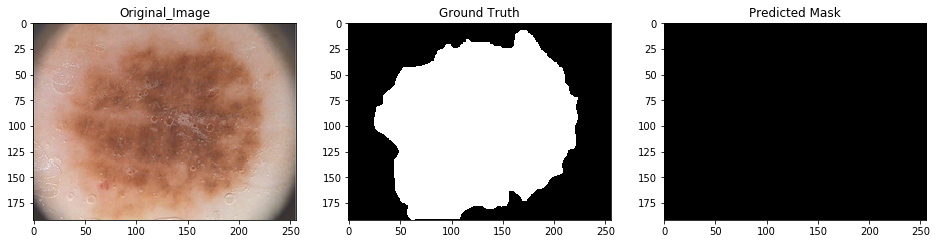

In [23]:
img_pred = model_nn.predict(x_test[20].reshape(1, 192, 256, 3))
plt.figure(figsize=(16, 16))
plt.subplot(1, 3, 1)
plt.imshow(x_test[20])
plt.title('Original_Image')
plt.subplot(1, 3, 2)
plt.imshow(y_test[20], cmap='gray')
plt.title('Ground Truth')
plt.subplot(1, 3, 3)
plt.imshow(img_pred.reshape(192, 256), cmap='gray')
plt.title('Predicted Mask')
plt.show()

